In [1]:
import numpy as np
from scipy.special import erf
from matplotlib import pyplot as plt

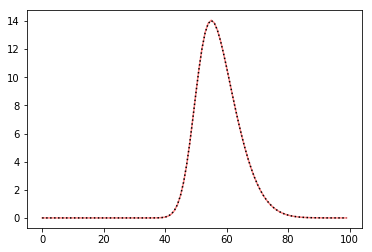

In [21]:
def skew_gauss(npix , A, x, omega, s, hw_sub=None):
    '''
    lam is wavelength variable, which is dependant variable in fitting
    '''
    if hw_sub is None:
        lam = np.arange(0,npix,1)
    else:
        lam = np.arange(0,npix)[:,None]+np.arange(-hw_sub,hw_sub+1,1)*1.0/hw_sub/2
        
    factor = np.sqrt(np.pi)/2.0
    gauss_comp = np.exp(-0.5*np.power((lam-x)/omega,2)) 
    erf_comp = factor * ( erf(s*(lam-x)/omega)+1.0 )
    
    if hw_sub is None:
        return  A*gauss_comp*erf_comp
    else:
        return np.mean(A*gauss_comp *erf_comp,axis=1)

npix = 100
wave = np.arange(0,npix)
flux_single = skew_gauss(npix, 10.0, 50.0, 10.0, 1.8, hw_sub=None)
flux_single1 = skew_gauss(npix, 10.0, 50.0, 10.0, 1.8, hw_sub=10)
plt.figure()
plt.plot(wave,flux_single,'r',alpha=0.5)
plt.plot(wave,flux_single1,'k:')
plt.show()



('initial center wave guess', 55)
  analysing data from multinest_out/.txt
{u'log_likelihood': -0.09551476882701238, u'parameters': [9.677654427456764, 49.700158903938686, 10.230803332137253, 1.9069119483138088]}


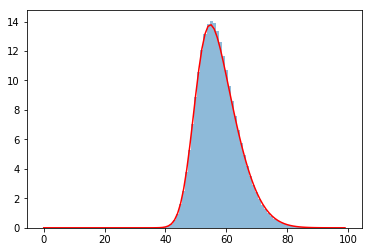

In [7]:
import numpy as np
from scipy.stats import norm
import time
import pymultinest
import json
import copy
obs = np.copy(flux_single)
id1 = np.where(obs>1e-8)
weight = np.zeros(shape=obs.shape)
weight[id1] = 1/obs[id1]

parameters = ['A', 'x', 'omega', 's']
n_params = len(parameters)

def loglike(cube,ndim, nparams):
    mock = skew_gauss(npix , cube[0], cube[1], cube[2], cube[3],2)
    return -0.5*np.sum( (obs-mock)**2*weight)

print('initial center wave guess',wave[np.argmax(obs)])

def prior(cube,ndim, nparams):
    cube[0] = 30*cube[0] #norm.ppf(cube[0],loc=10,scale=1) #norm.ppf(cube[0],loc=0.3,scale=0.1) #normalization
    cube[1] = norm.ppf(cube[1],loc=wave[np.argmax(obs)],scale=15) #norm.ppf(cube[1],loc=3050,scale=5)  #center x
    cube[2] = 20*cube[2]#norm.ppf(cube[2],loc=10,scale=3) #omega,scatter
    cube[3] = 20.0*cube[3] - 10.0 #norm.ppf(cube[3],loc=1.8,scale=0.3) #skewness [-20,20]

pymultinest.run(loglike, prior, n_params, resume =False, verbose = True,outputfiles_basename='multinest_out/',
                   n_live_points=200, evidence_tolerance=0.5,sampling_efficiency=0.05,
                   importance_nested_sampling=False,const_efficiency_mode=True, multimodal=True)

json.dump(parameters, open('multinest_out/params.json', 'w'))

res = pymultinest.Analyzer(outputfiles_basename='multinest_out/', n_params = n_params)
xx = res.get_best_fit()
print(xx)
fit_par = xx['parameters']

plt.figure()
plt.bar(wave,obs,alpha=0.5,width=1)
#skew_gauss(wave , fit_par[0], fit_par[1], fit_par[3], fit_par[4])
plt.plot(wave,skew_gauss(npix , fit_par[0], fit_par[1], fit_par[2], fit_par[3],hw_sub=10),color='red')
#plt.plot(wave,skew_gauss(npix , hw_sub=None,*fit_par),color='red')
plt.show()

In [9]:
res.get_stats()

{u'global evidence': -12.057117116519157,
 u'global evidence error': 0.2237025277413868,
 u'marginals': [{u'1sigma': [8.90295481110638, 10.899827606874549],
   u'2sigma': [8.122650142409466, 11.92223490779603],
   u'3sigma': [7.292770610651455, 13.67848876717463],
   u'5sigma': [5.9179295465719095, 19.31139812226781],
   u'median': 9.874360300388734,
   u'q01%': 7.857181300133523,
   u'q10%': 8.66368655272631,
   u'q25%': 9.21048158050168,
   u'q75%': 10.588621390639942,
   u'q90%': 11.211750651350465,
   u'q99%': 12.887558190942215,
   u'sigma': 0.9984363978840847},
  {u'1sigma': [49.20470060029057, 50.77506138583671],
   u'2sigma': [48.523110313197485, 51.754755387608206],
   u'3sigma': [47.91467867266735, 53.26774343871277],
   u'5sigma': [46.91208200948495, 60.89854445544044],
   u'median': 49.958019698908934,
   u'q01%': 48.25822958821372,
   u'q10%': 48.9955642846585,
   u'q25%': 49.46877051518968,
   u'q75%': 50.48259255917455,
   u'q90%': 50.996594429459016,
   u'q99%': 52.1996

In [20]:
npix=8
hw_sub = 5
x = np.arange(0,npix)[:,None]+np.arange(-hw_sub,hw_sub+1,1)*1.0/hw_sub/2
x

array([[-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       [ 0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5],
       [ 1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5],
       [ 2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,  3.4,  3.5],
       [ 3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,  4.5],
       [ 4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5],
       [ 5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5],
       [ 6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5]])

In [15]:
np.arange(-hw_sub,hw_sub+1,1)*1.0/hw_sub/2

array([-0.5  , -0.375, -0.25 , -0.125,  0.   ,  0.125,  0.25 ,  0.375,
        0.5  ])

In [22]:
def double_peak(npix , A1, x1, omega1, s1, f_ratio, offset, omega2, s2, hw_sub=None):
    if hw_sub is None:
        lam = np.arange(0,npix,1)
    else:
        lam = np.arange(0,npix)[:,None]+np.arange(-hw_sub,hw_sub+1,1)*1.0/hw_sub/2
    
    factor = np.sqrt(np.pi)/2.0
    
    gauss_comp1 = np.exp(-0.5*np.power((lam-x1)/omega1,2)) 
    erf_comp1 = factor * ( erf(s1*(lam-x1)/omega1)+1.0 )
    subfunc1 = A1*gauss_comp1*erf_comp1

    x2 = x1 + offset
    gauss_comp2 = np.exp(-0.5*np.power((lam-x2)/omega2,2)) 
    erf_comp2 = factor * ( erf(s2*(lam-x2)/omega2)+1.0 )
    subfunc2 = f_ratio*A1*gauss_comp2*erf_comp2
    
    subfunc = subfunc1 + subfunc2
    if hw_sub is None:
        return  subfunc
    else:
        return np.mean(subfunc,axis=1)

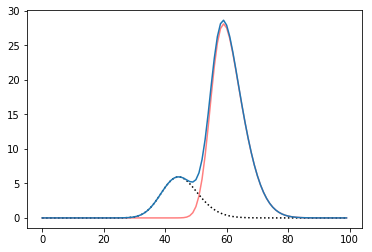

In [23]:
npix = 100
wave = np.arange(0,npix)
flux_0 = skew_gauss(npix, 20.0, 55.0, 8.0, 1.8, hw_sub=None)
flux_1 = skew_gauss(npix, 5.0, 40.0, 8.0, 1., hw_sub=None)
plt.figure()
plt.plot(wave,flux_0,'r',alpha=0.5)
plt.plot(wave,flux_1,'k:')
flux_tot = flux_0 + flux_1
plt.plot(wave,flux_tot)
plt.show()


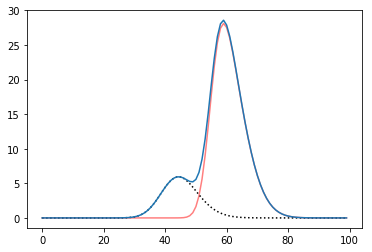

In [24]:
npix = 100
wave = np.arange(0,npix)
flux_double = double_peak(npix , 5.0, 40.0, 8.0, 1.0, 4.0, 15.0, 8.0, 1.8, hw_sub=5)
plt.figure()
plt.plot(wave,flux_0,'r',alpha=0.5)
plt.plot(wave,flux_1,'k:')
plt.plot(wave,flux_double)
plt.show()

('initial center wave guess', 55)
  analysing data from multinest_out/.txt
{u'log_likelihood': -0.19526720218072965, u'parameters': [0.9002986503626449, 49.47935494754439, 2.264626708684415, -0.10781014136048483, 11.391506342154669, 0.7652425183828715, 9.836242877714245, 1.6819493631618236]}


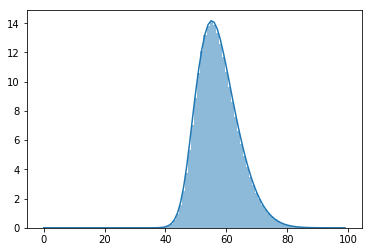

In [11]:
import numpy as np
from scipy.stats import norm
import time
import pymultinest
import json
import copy
obs = np.copy(flux_single)
id1 = np.where(obs>1e-8)
weight = np.zeros(shape=obs.shape)
weight[id1] = 1/obs[id1]

parameters = ['A1', 'x1', 'omega1', 's1', 'flux_ratio', 'offset', 'omega2', 's2']
n_params = len(parameters)

def loglike(cube,ndim, nparams):
    mock = double_peak(npix , cube[0], cube[1], cube[2], cube[3], cube[4], cube[5], cube[6], cube[7],hw_sub=2)
    return -0.5*np.sum( (obs-mock)**2*weight)

print('initial center wave guess',wave[np.argmax(obs)])

def prior(cube,ndim, nparams):
    cube[0] = 30*cube[0] #norm.ppf(cube[0],loc=10,scale=1) #norm.ppf(cube[0],loc=0.3,scale=0.1) #normalization
    cube[1] = norm.ppf(cube[1],loc=wave[np.argmax(obs)],scale=15) #norm.ppf(cube[1],loc=3050,scale=5)  #center x
    cube[2] = 20*cube[2]#norm.ppf(cube[2],loc=10,scale=3) #omega,scatter
    cube[3] = 20.0*cube[3] - 10.0 #norm.ppf(cube[3],loc=1.8,scale=0.3) #skewness [-20,20]
    cube[4] = 20.0*cube[4] + 1.0 #flux ratio
    cube[5] = 30*cube[5] #offset
    cube[6] = 20*cube[6] #omega2
    cube[7] = 20.0*cube[7] - 10.0 #skewness2
    
pymultinest.run(loglike, prior, n_params, resume =False, verbose = True,outputfiles_basename='multinest_out/',
                   n_live_points=200, evidence_tolerance=0.5,sampling_efficiency=0.05,
                   importance_nested_sampling=False,const_efficiency_mode=True, multimodal=True)

json.dump(parameters, open('multinest_out/params.json', 'w'))

res = pymultinest.Analyzer(outputfiles_basename='multinest_out/', n_params = n_params)
xx = res.get_best_fit()
print(xx)
fit_par = xx['parameters']

plt.figure()
plt.bar(wave,obs,alpha=0.5,width=1)
#skew_gauss(wave , fit_par[0], fit_par[1], fit_par[3], fit_par[4])
plt.plot(wave,double_peak(npix , *fit_par,hw_sub=2))
#plt.plot(wave,skew_gauss(npix , hw_sub=None,*fit_par),color='red')
plt.show()

In [42]:
res.get_stats()

{u'global evidence': -21.35197536909252,
 u'global evidence error': 0.29629325331024037,
 u'marginals': [{u'1sigma': [3.378909219336813, 5.5170543193725],
   u'2sigma': [2.6617508487750654, 7.115309797610267],
   u'3sigma': [1.8639300549973028, 7.982566393598815],
   u'5sigma': [0.9594053497176357, 8.083393184764837],
   u'median': 4.218485345830564,
   u'q01%': 2.3621466196905723,
   u'q10%': 3.2102145012914183,
   u'q25%': 3.59447288403306,
   u'q75%': 5.062382741199349,
   u'q90%': 5.952292343971752,
   u'q99%': 7.534978831693821,
   u'sigma': 1.0690725500178435},
  {u'1sigma': [37.66222409671887, 47.66202891990344],
   u'2sigma': [36.39945897167071, 50.09727096462952],
   u'3sigma': [35.03806636594315, 52.19038999039456],
   u'5sigma': [32.87388552136654, 60.37513176707333],
   u'median': 39.95733016425751,
   u'q01%': 35.85166233357569,
   u'q10%': 37.31059563265243,
   u'q25%': 38.2639733516355,
   u'q75%': 46.42999570209431,
   u'q90%': 48.38515345723068,
   u'q99%': 51.01962607